In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [39]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [40]:
df = pd.read_csv('SPAS-Dataset-BD.csv')

In [41]:
# Initial Data Inspection
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (4608, 15)

First 5 rows:


,Area,AP Ratio,District,Season,Avg Temp,Avg Humidity,Crop Name,Transplant,Growth,Harvest,Production,Max Temp,Min Temp,Max Relative Humidity,Min Relative Humidity
0,177321,0.8510272331,Bagerhat,Kharif 2,26.0,72.5,Aman,June,July to Oct,Nov to Dec,150905,40,12.0,60,85
1,25646,1.175777899,Bandarban,Kharif 2,26.0,72.5,Aman,June,July to Oct,Nov to Dec,30154,40,12.0,60,85
2,231401,0.7705887183,Barguna,Kharif 2,26.0,72.5,Aman,June,July to Oct,Nov to Dec,178315,40,12.0,60,85
3,302665,0.7571043893,Barishal,Kharif 2,26.0,72.5,Aman,June,July to Oct,Nov to Dec,229149,40,12.0,60,85
4,388575,1.100652384,Bhola,Kharif 2,26.0,72.5,Aman,June,July to Oct,Nov to Dec,427686,40,12.0,60,85


In [5]:
print(f"   - Rows: {df.shape[0]}")
print(f"   - Columns: {df.shape[1]}")

   - Rows: 4608
   - Columns: 15


In [6]:
print("Column Names and Types:")
print(df.dtypes)

Column Names and Types:
Area                       int64
AP Ratio                  object
District                  object
Season                    object
Avg Temp                 float64
Avg Humidity             float64
Crop Name                 object
Transplant                object
Growth                    object
Harvest                   object
Production                 int64
Max Temp                   int64
Min Temp                 float64
Max Relative Humidity      int64
Min Relative Humidity      int64
dtype: object


In [7]:
print("Check for summary")
print("-"*20)
print(df.info()) 

Check for summary
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4608 entries, 0 to 4607
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Area                   4608 non-null   int64  
 1   AP Ratio               4608 non-null   object 
 2   District               4608 non-null   object 
 3   Season                 4607 non-null   object 
 4   Avg Temp               4608 non-null   float64
 5   Avg Humidity           4608 non-null   float64
 6   Crop Name              4608 non-null   object 
 7   Transplant             4608 non-null   object 
 8   Growth                 4608 non-null   object 
 9   Harvest                4608 non-null   object 
 10  Production             4608 non-null   int64  
 11  Max Temp               4608 non-null   int64  
 12  Min Temp               4608 non-null   float64
 13  Max Relative Humidity  4608 non-null   int64  
 14  Min Relative Humi

In [8]:
print("Statistical Summary")
print(df.describe())

Statistical Summary
                Area     Avg Temp  Avg Humidity    Production     Max Temp  \
count    4608.000000  4608.000000   4608.000000  4.608000e+03  4608.000000   
mean     8084.877604    23.878472     71.597222  1.443418e+04    30.736111   
std     42154.348588     4.721549     11.245552  6.562959e+04     5.956486   
min         0.000000    11.500000     35.000000  0.000000e+00    15.000000   
25%        61.000000    20.000000     67.500000  1.197500e+02    25.000000   
50%       280.000000    25.000000     72.500000  7.260000e+02    30.000000   
75%       821.250000    27.500000     80.000000  2.881000e+03    35.000000   
max    663734.000000    34.500000     90.000000  1.077242e+06    47.000000   

          Min Temp  Max Relative Humidity  Min Relative Humidity  
count  4608.000000            4608.000000            4608.000000  
mean     17.020833              61.513889              81.680556  
std       5.407911              12.785919              11.340477  
min      

In [9]:
print("Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

Missing Values:
        Missing Count  Percentage
Season              1    0.021701


As our data set is clean we are introducing a few random data to clean and demonstrate data cleaning and proprocessing

In [10]:
df_clean = df.copy()

In [11]:
print("=== Handling Missing Season Value ===")
if df_clean['Season'].isnull().sum() > 0:
    missing_season_row = df_clean[df_clean['Season'].isnull()]
    print(f"   Row with missing Season:")
    print(missing_season_row[['District', 'Crop Name', 'Transplant', 'Growth', 'Harvest']])
    
    # Filling with mode (as this is a catagorical data)
    season_mode = df_clean['Season'].mode()[0]
    df_clean['Season'].fillna(season_mode, inplace=True)
    print(f"    Filled with mode: {season_mode}")

=== Handling Missing Season Value ===
   Row with missing Season:
     District   Crop Name Transplant          Growth              Harvest
4546  Barguna  Wood Apple        May  June to August  August to September
    Filled with mode: Kharif 2


In [12]:
print("=== Checking for Duplicates ===")
duplicates = df_clean.duplicated().sum()
print(f"   Found {duplicates} duplicate rows")
if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"    Removed duplicates. New shape: {df_clean.shape}")

=== Checking for Duplicates ===
   Found 0 duplicate rows


In [13]:
np.random.seed(42)
missing_indices = np.random.choice(df_clean.index, size=int(0.05*len(df_clean)), replace=False)
df_clean.loc[missing_indices, 'AP Ratio'] = np.nan

print(f"Simulated {len(missing_indices)} missing values in AP Ratio for cleaning demonstration.")

print("=== Validating AP Ratio column ===")

# Convert to numeric (text → float)
df_clean['AP Ratio'] = pd.to_numeric(df_clean['AP Ratio'], errors='coerce')

# Count missing after conversion
ap_missing = df_clean['AP Ratio'].isnull().sum()

if ap_missing > 0:
    print(f"     Found {ap_missing} invalid Area to Production Ratio values")

    # Check skewness
    ap_skew = abs(df_clean["AP Ratio"].skew())

    if ap_skew < 0.5:
        ap_mean = df_clean['AP Ratio'].mean()
        df_clean['AP Ratio'] = df_clean["AP Ratio"].fillna(ap_mean)
        print(f"    Filled missing values with mean: {ap_mean:.4f}")
    else:
        ap_median = df_clean['AP Ratio'].median()
        df_clean['AP Ratio'] = df_clean["AP Ratio"].fillna(ap_median)
        print(f"    Filled missing values with median: {ap_median:.4f}")

else:
    print("No Invalid Area to Production Ratios found")



Simulated 230 missing values in AP Ratio for cleaning demonstration.
=== Validating AP Ratio column ===
     Found 630 invalid Area to Production Ratio values
    Filled missing values with median: 2.5117


In [14]:
print("=== Data Cleaning Complete! ===")
print(f"   Final Shape: {df_clean.shape}")
print(f"   Missing Values: {df_clean.isnull().sum().sum()}")


=== Data Cleaning Complete! ===
   Final Shape: (4608, 15)
   Missing Values: 0


Target Variable (Production) Statistics:
count    4.608000e+03
mean     1.443418e+04
std      6.562959e+04
min      0.000000e+00
25%      1.197500e+02
50%      7.260000e+02
75%      2.881000e+03
max      1.077242e+06
Name: Production, dtype: float64


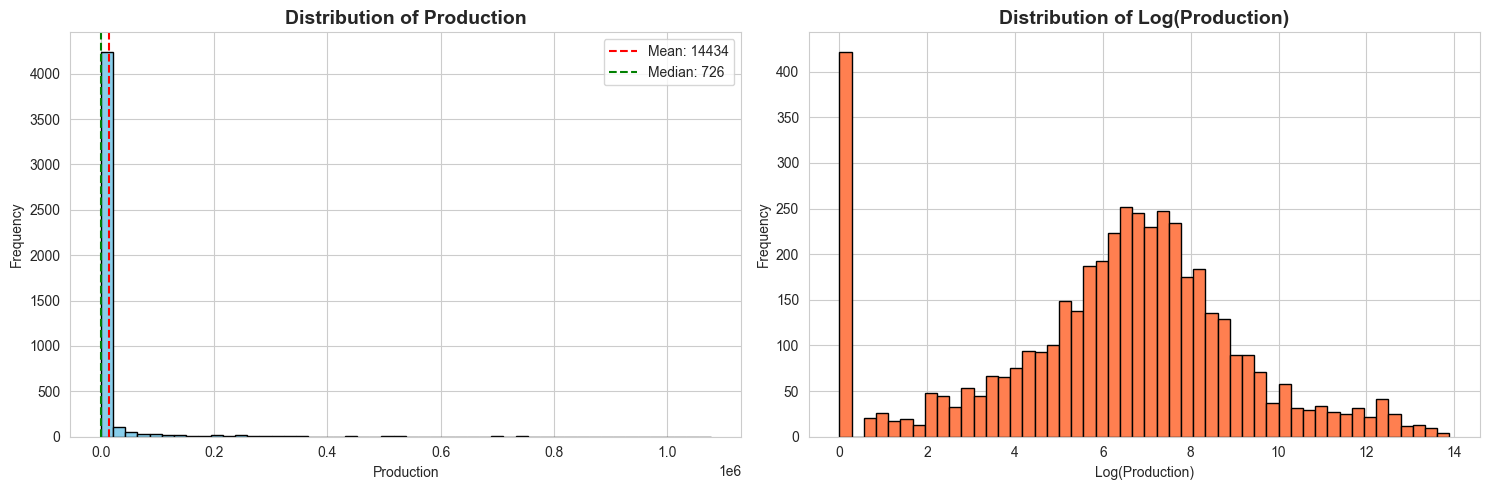

In [15]:
#Distribution of Target Variable (Production)
print("Target Variable (Production) Statistics:")
print(df_clean['Production'].describe())

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Production distribution
axes[0].hist(df_clean['Production'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Production', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Production')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df_clean['Production'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_clean["Production"].mean():.0f}')
axes[0].axvline(df_clean['Production'].median(), color='green', linestyle='--', 
                label=f'Median: {df_clean["Production"].median():.0f}')
axes[0].legend()

# Log-transformed production (to see distribution better)
axes[1].hist(np.log1p(df_clean['Production']), bins=50, color='coral', edgecolor='black')
axes[1].set_title('Distribution of Log(Production)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Log(Production)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('production_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:

print("=== Shapiro-Wilk Test for Normality ===")

data = df_clean['Production']

stat, p_value = shapiro(data)
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4g}")

if p_value > 0.05:
    print("Data is likely normally distributed (Fail to reject H0)")
else:
    print("Data is not normally distributed (Reject H0)")


=== Shapiro-Wilk Test for Normality ===
Shapiro-Wilk Test Statistic: 0.2179, p-value: 5.12e-88
Data is not normally distributed (Reject H0)


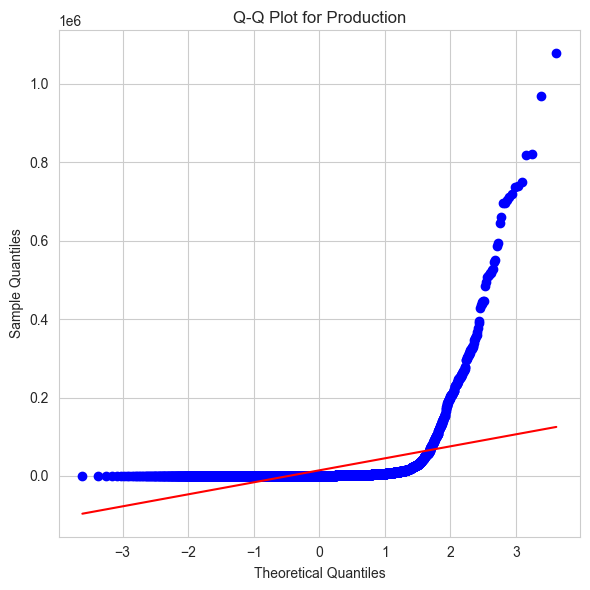

In [17]:
#  Q-Q Plot
plt.figure(figsize=(6, 6))
stats.probplot(data, dist="norm", plot=plt)
plt.title("Q-Q Plot for Production")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.tight_layout()
plt.savefig('production_Q_Q_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
#Investigate zero production crops
zero_production = df_clean[df_clean['Production'] == 0]
print(f"Total crops with zero production: {len(zero_production)}")
print(zero_production['Crop Name'].value_counts())

Total crops with zero production: 422
Crop Name
Cheena            46
Tobacco           40
Arhar             31
Malta             30
Shalgom           29
Maize 1           28
Oal Kachu         26
Pineapple         23
Palmyra Palm      18
Safeda            16
Gram              15
Jute              13
Patal             12
Ginger            11
Mukhi Kachu       11
Carrot            10
Mashkalai         10
Motor              9
Wheat              7
Mug                6
Kolmi Shak         5
Dalim              5
Date Palm          4
Groundnut          4
Sesame             3
Jamrul             3
Lentil             2
Maize 2            2
Green Palmyra      1
Kakrol             1
Rape & Mustard     1
Name: count, dtype: int64


In [19]:
# Check area
print("Area values for zero production crops:")
print(zero_production['Area'].describe())

#Check seasons with zero production
print("\nSeasons with zero production:")
print(zero_production['Season'].value_counts())

#Check districts with zero production
print("\nDistricts with zero production:")
print(zero_production['District'].value_counts())

Area values for zero production crops:
count    422.000000
mean       0.120853
std        0.915473
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       15.000000
Name: Area, dtype: float64

Seasons with zero production:
Season
Kharif 2    218
Kharif 1    113
Rabi         91
Name: count, dtype: int64

Districts with zero production:
District
Habiganj      18
CoxsBazar     15
Sunamganj     14
Jhallokati    12
Patuakhali    12
              ..
Jamalpur       2
Kurigram       2
Rangpur        2
Dinajpur       1
Thakurgaon     1
Name: count, Length: 64, dtype: int64


In [20]:
zero_analysis = zero_production.groupby('Crop Name').agg({
    'Production': 'count',
    'Area': ['mean', 'min', 'max'],
    'District': 'nunique',
    'Season': 'nunique'
}).round(2)

print("Zero Production Analysis:")
print(zero_analysis)

Zero Production Analysis:
               Production  Area         District  Season
                    count  mean min max  nunique nunique
Crop Name                                               
Arhar                  31  0.23   0   3       31       1
Carrot                 10  0.00   0   0       10       1
Cheena                 46  0.11   0   3       46       1
Dalim                   5  0.00   0   0        5       1
Date Palm               4  0.00   0   0        4       1
Ginger                 11  0.00   0   0       11       1
Gram                   15  0.00   0   0       15       1
Green Palmyra           1  4.00   4   4        1       1
Groundnut               4  0.00   0   0        4       1
Jamrul                  3  3.67   0   7        3       1
Jute                   13  0.00   0   0       13       1
Kakrol                  1  0.00   0   0        1       1
Kolmi Shak              5  0.00   0   0        5       1
Lentil                  2  0.00   0   0        2       1
Maize

In [21]:
# Remove the data with quality issues (zero area, zero production)
before = len(df_clean)
df_clean = df_clean[~((df_clean['Area'] == 0) & (df_clean['Production'] == 0))].copy()
removed_count = before - len(df_clean)

print(f"Original: {before} records")
print(f"Cleaned: {len(df_clean)} records") 
print(f"Removed: {removed_count} records ({(removed_count/before*100):.1f}%)")

# Keeping the genuine crop failures (Area>0, Production=0)
genuine_failures = df_clean[(df_clean['Area'] > 0) & (df_clean['Production'] == 0)]
print(f"Genuine crop failures preserved: {len(genuine_failures)}")

Original: 4608 records
Cleaned: 4199 records
Removed: 409 records (8.9%)
Genuine crop failures preserved: 13


Top 10 Crops by Average Production:
                     mean       sum  count
Crop Name                                 
Boro        310707.546875  19885283     64
Aman        225590.140625  14437769     64
Jute        151472.294118   7725087     51
Maize 2      57478.370968   3563659     62
Sugarcane    52070.750000   3332528     64
Aus          51323.546875   3284707     64
Onion        35448.953125   2268733     64
Wheat        19041.526316   1085367     57
Mango        18978.078125   1214597     64
Jack Fruit   17140.640625   1097001     64


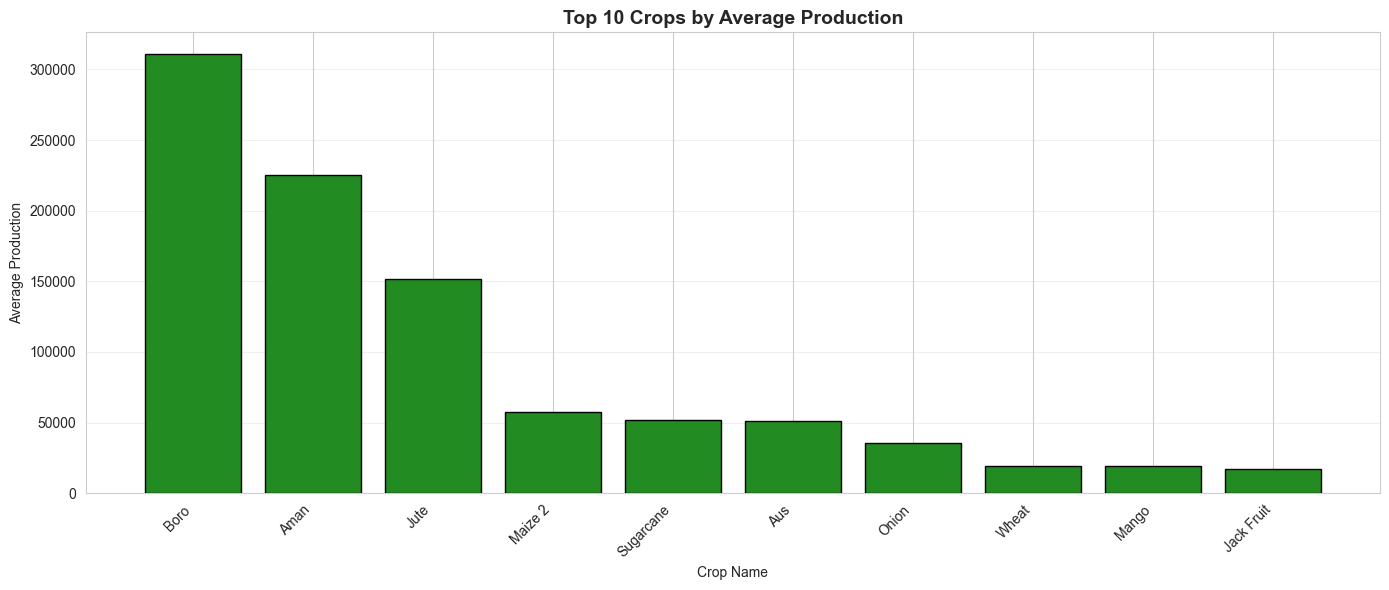

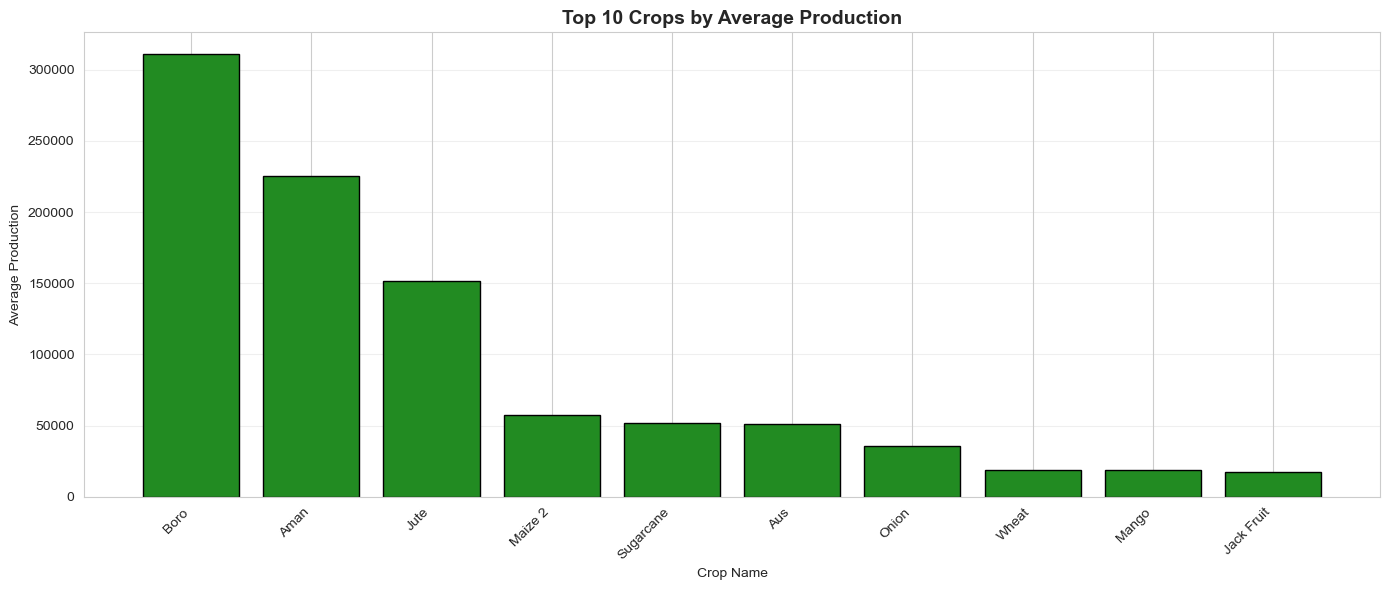

In [22]:
#Crop-wise Production
print("Top 10 Crops by Average Production:")
crop_production = df_clean.groupby('Crop Name')['Production'].agg(['mean', 'sum', 'count']).sort_values('mean', ascending=False)
print(crop_production.head(10))

plt.figure(figsize=(14, 6))
top_crops = crop_production.head(10)
plt.bar(range(len(top_crops)), top_crops['mean'], color='forestgreen', edgecolor='black')
plt.xticks(range(len(top_crops)), top_crops.index, rotation=45, ha='right')
plt.title('Top 10 Crops by Average Production', fontsize=14, fontweight='bold')
plt.xlabel('Crop Name')
plt.ylabel('Average Production')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('top_crops.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
#District-wise Production
print("Top 10 Districts by Total Production:")
district_production = df_clean.groupby('District')['Production'].agg(['sum', 'mean']).sort_values('sum', ascending=False)
print(district_production.head(10))

Top 10 Districts by Total Production:
                sum          mean
District                         
Dinajpur    2410338  33948.422535
Natore      2307299  33439.115942
Mymensingh  2225913  34244.815385
Rajshahi    2216731  32598.985294
Pabna       2038058  29971.441176
Naogaon     1951151  29121.656716
Faridpur    1828770  26503.913043
Kushtia     1787056  26672.477612
Bogura      1772925  25694.565217
Jashore     1741470  25609.852941


In [24]:
#Season-wise Production
print("Season-wise Production:")
season_production = df_clean.groupby('Season')['Production'].agg(['mean', 'sum', 'count'])
print(season_production)

Season-wise Production:
                  mean       sum  count
Season                                 
Kharif 1  11144.405063  15847344   1422
Kharif 2  13542.831439  21451845   1584
Rabi      24487.429170  29213503   1193


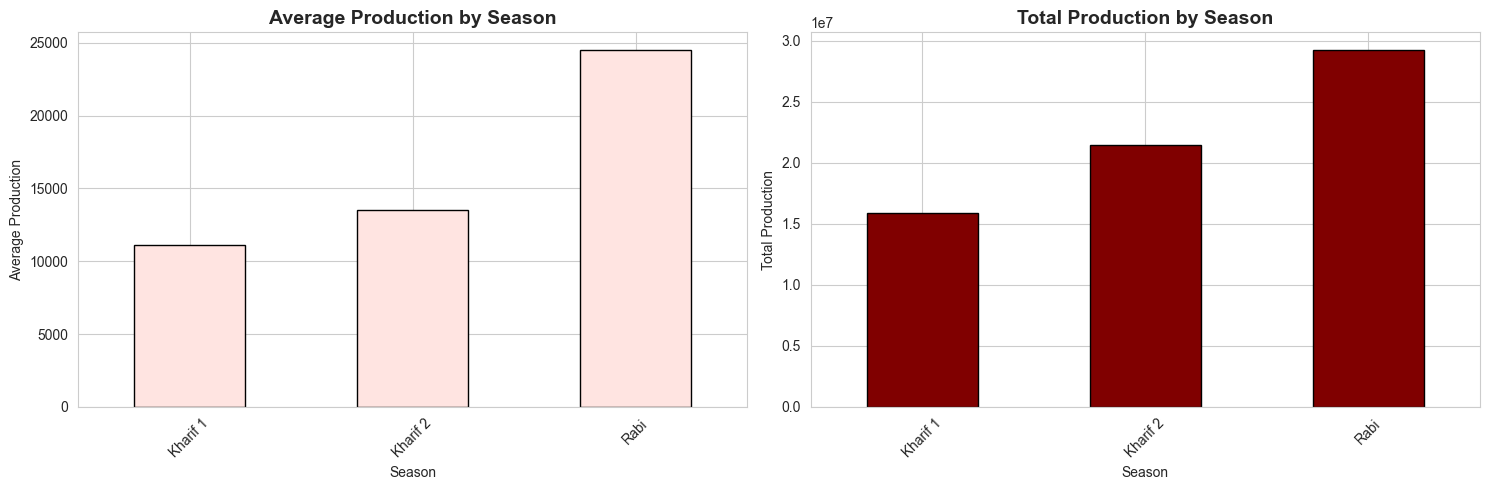

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#Season-wise average production
season_production['mean'].plot(kind='bar', ax=axes[0], color='mistyrose', edgecolor='black')
axes[0].set_title('Average Production by Season', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Average Production')
axes[0].tick_params(axis='x', rotation=45)

#Season-wise total production
season_production['sum'].plot(kind='bar', ax=axes[1], color='maroon', edgecolor='black')
axes[1].set_title('Total Production by Season', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Total Production')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('season_production.png', dpi=300, bbox_inches='tight')
plt.show()

Climate Features Analysis:


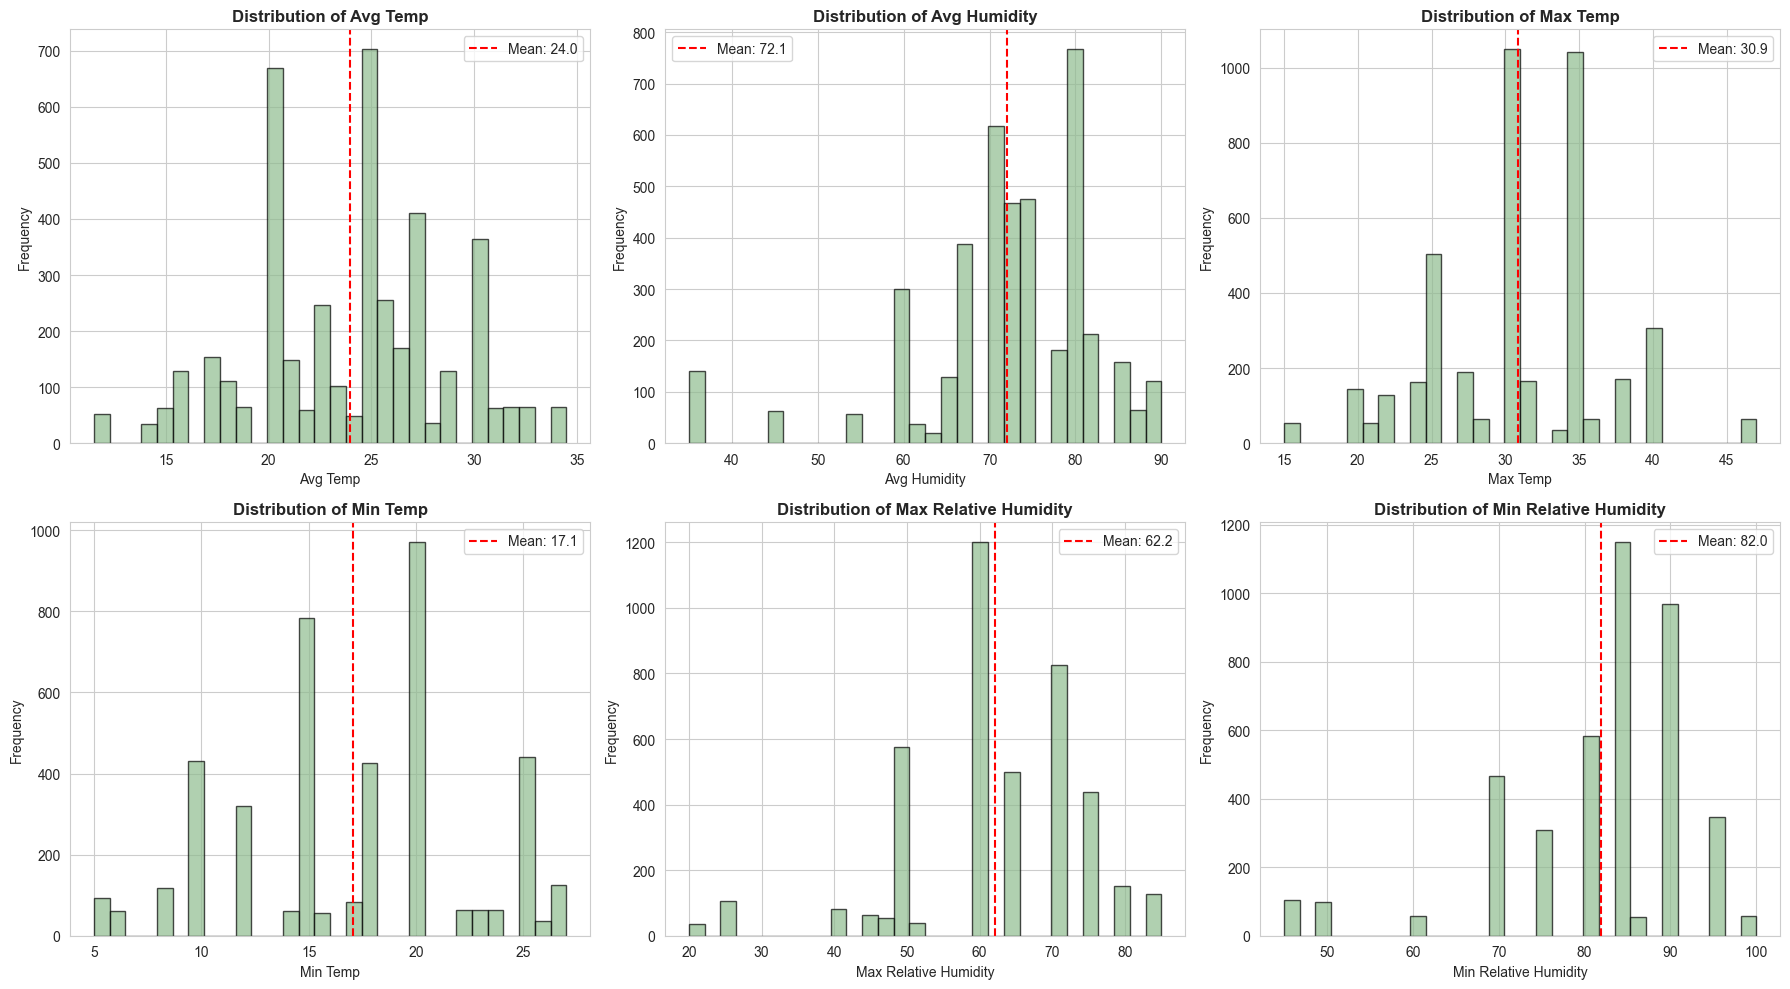

In [26]:
#Climate Features Analysis
print("Climate Features Analysis:")
climate_features = ['Avg Temp', 'Avg Humidity', 'Max Temp', 'Min Temp', 
                    'Max Relative Humidity', 'Min Relative Humidity']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(climate_features):
    axes[idx].hist(df_clean[feature], bins=30, color='darkseagreen', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(df_clean[feature].mean(), color='red', linestyle='--', 
                      label=f'Mean: {df_clean[feature].mean():.1f}')
    axes[idx].legend()

plt.tight_layout()
plt.savefig('climate_features.png', dpi=300, bbox_inches='tight')
plt.show()

Correlation with Production:
Production               1.000000
Area                     0.888339
Max Temp                 0.244238
Avg Temp                 0.092874
Min Relative Humidity    0.015372
AP Ratio                 0.010248
Avg Humidity            -0.010411
Max Relative Humidity   -0.032419
Min Temp                -0.104916
Name: Production, dtype: float64


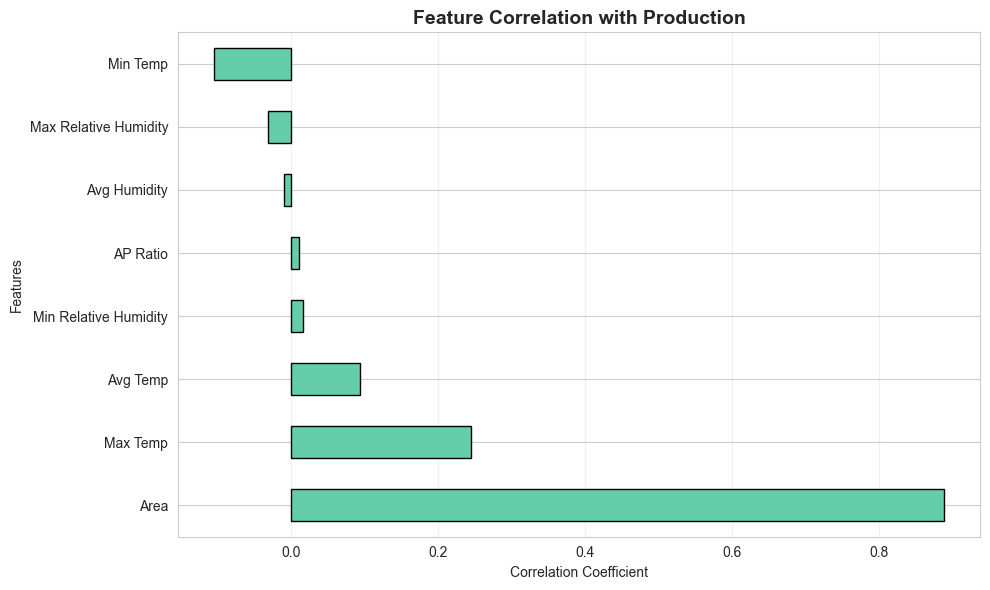

In [27]:
#Correlation Analysis
print("Correlation with Production:")
numeric_features = ['Area', 'AP Ratio', 'Avg Temp', 'Avg Humidity', 'Max Temp', 
                    'Min Temp', 'Max Relative Humidity', 'Min Relative Humidity']
correlations = df_clean[numeric_features + ['Production']].corr()['Production'].sort_values(ascending=False)
print(correlations)

plt.figure(figsize=(10, 6))
correlations.drop('Production').plot(kind='barh', color='mediumaquamarine', edgecolor='black')
plt.title('Feature Correlation with Production', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('correlation.png', dpi=300, bbox_inches='tight')
plt.show()

Relationship between Area and Production:


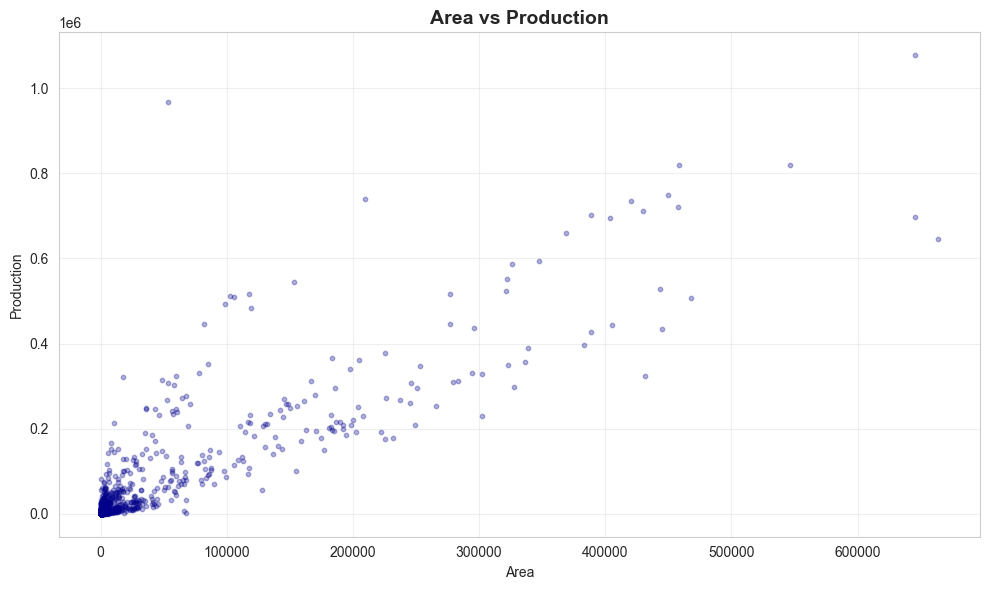

In [28]:
#Area vs Production Relationship
print("Relationship between Area and Production:")
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['Area'], df_clean['Production'], alpha=0.3, c='darkblue', s=10)
plt.title('Area vs Production', fontsize=14, fontweight='bold')
plt.xlabel('Area')
plt.ylabel('Production')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('area_vs_production.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Engineering

In [29]:
df_model = df_clean.copy()

#Create new features
print("=== Creating New Features ===")
#Yield per unit area
df_model['Yield_per_Area'] = df_model['Production'] / df_model['Area']
print("Created: Yield_per_Area")

#Temperature range
df_model['Temp_Range'] = df_model['Max Temp'] - df_model['Min Temp']
print("\nCreated: Temp_Range")

#Humidity range
df_model['Humidity_Range'] = df_model['Max Relative Humidity'] - df_model['Min Relative Humidity']
print("\nCreated: Humidity_Range")

#Is temperature optimal (20-30 degrees)
df_model['Optimal_Temp'] = ((df_model['Avg Temp'] >= 20) & (df_model['Avg Temp'] <= 30)).astype(int)
print("\nCreated: Optimal_Temp")

#Is humidity optimal (60-80%)
df_model['Optimal_Humidity'] = ((df_model['Avg Humidity'] >= 60) & (df_model['Avg Humidity'] <= 80)).astype(int)
print("\nCreated: Optimal_Humidity")

=== Creating New Features ===
Created: Yield_per_Area

Created: Temp_Range

Created: Humidity_Range

Created: Optimal_Temp

Created: Optimal_Humidity


In [30]:
print("=== Encoding Categorical Variables ===")

categorical_columns = ['District', 'Season', 'Crop Name', 'Transplant', 'Growth', 'Harvest']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_model[f'{col}_encoded'] = le.fit_transform(df_model[col])
    label_encoders[col] = le
    print(f"    Encoded: {col} ({len(le.classes_)} unique values)")

print("Final Feature Set:")
print(df_model.columns.tolist())

=== Encoding Categorical Variables ===
    Encoded: District (64 unique values)
    Encoded: Season (3 unique values)
    Encoded: Crop Name (73 unique values)
    Encoded: Transplant (19 unique values)
    Encoded: Growth (32 unique values)
    Encoded: Harvest (34 unique values)
Final Feature Set:
['Area', 'AP Ratio', 'District', 'Season', 'Avg Temp', 'Avg Humidity', 'Crop Name', 'Transplant', 'Growth', 'Harvest', 'Production', 'Max Temp', 'Min Temp', 'Max Relative Humidity', 'Min Relative Humidity', 'Yield_per_Area', 'Temp_Range', 'Humidity_Range', 'Optimal_Temp', 'Optimal_Humidity', 'District_encoded', 'Season_encoded', 'Crop Name_encoded', 'Transplant_encoded', 'Growth_encoded', 'Harvest_encoded']


In [31]:
feature_columns = ['Area', 'AP Ratio', 'Avg Temp', 'Avg Humidity', 'Max Temp', 'Min Temp',
                   'Max Relative Humidity', 'Min Relative Humidity', 'Temp_Range', 
                   'Humidity_Range', 'Optimal_Temp', 'Optimal_Humidity',
                   'District_encoded', 'Season_encoded', 'Crop Name_encoded',
                   'Transplant_encoded', 'Growth_encoded', 'Harvest_encoded']

X = df_model[feature_columns]
y = df_model['Production']

print(f"Features Shape: {X.shape}")
print(f"Target Shape: {y.shape}")

Features Shape: (4199, 18)
Target Shape: (4199,)


In [32]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")

#Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled using StandardScaler")

Train Set: 3359 samples
Test Set: 840 samples
Features scaled using StandardScaler


# Model Training

In [33]:
#Train Multiple Models
print("=== Training Models ===")
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=6, learning_rate=0.1)
}

results = {}

for name, model in models.items():
    print(f"\n   Training {name}...")
    
    # Train
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }
    
    print(f"      MAE:  {mae:,.2f}")
    print(f"      RMSE: {rmse:,.2f}")
    print(f"      R²:   {r2:.4f}")

=== Training Models ===

   Training Linear Regression...
      MAE:  10,409.36
      RMSE: 38,078.18
      R²:   0.6929

   Training Decision Tree...
      MAE:  3,557.18
      RMSE: 24,997.60
      R²:   0.8677

   Training Random Forest...
      MAE:  2,869.33
      RMSE: 25,960.36
      R²:   0.8573

   Training XGBoost...
      MAE:  4,421.07
      RMSE: 35,336.79
      R²:   0.7355


Model Performance Comparison:
            Model          MAE         RMSE       R²
    Decision Tree  3557.179189 24997.602274 0.867656
    Random Forest  2869.334839 25960.361070 0.857266
          XGBoost  4421.068359 35336.794195 0.735539
Linear Regression 10409.360963 38078.181491 0.692915


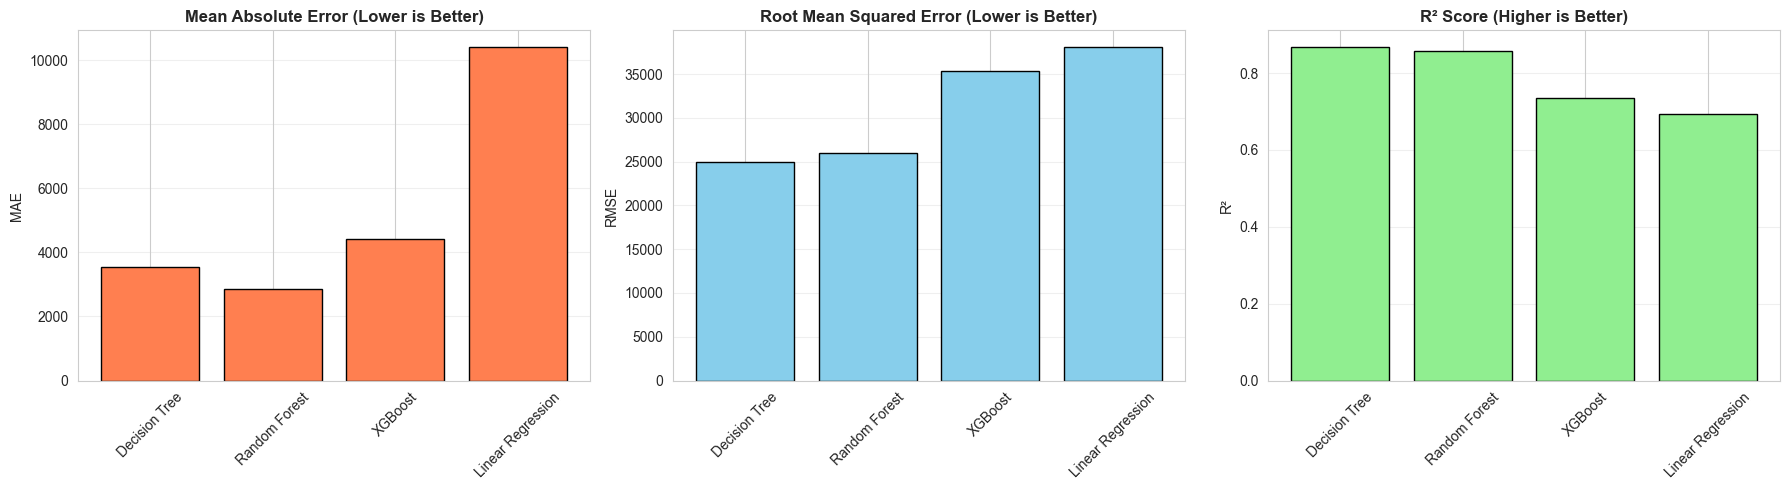

In [34]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results.keys()],
    'RMSE': [results[m]['RMSE'] for m in results.keys()],
    'R²': [results[m]['R2'] for m in results.keys()]
}).sort_values('R²', ascending=False)

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE Comparison
axes[0].bar(comparison_df['Model'], comparison_df['MAE'], color='coral', edgecolor='black')
axes[0].set_title('Mean Absolute Error (Lower is Better)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# RMSE Comparison
axes[1].bar(comparison_df['Model'], comparison_df['RMSE'], color='skyblue', edgecolor='black')
axes[1].set_title('Root Mean Squared Error (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# R² Comparison
axes[2].bar(comparison_df['Model'], comparison_df['R²'], color='lightgreen', edgecolor='black')
axes[2].set_title('R² Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Best Model: Decision Tree
Top 15 Important Features:
              Feature  Importance
                 Area    0.864190
             AP Ratio    0.099231
      Harvest_encoded    0.025654
     District_encoded    0.004433
       Season_encoded    0.003400
    Crop Name_encoded    0.000773
Max Relative Humidity    0.000661
             Avg Temp    0.000661
       Growth_encoded    0.000399
   Transplant_encoded    0.000352
     Optimal_Humidity    0.000131
             Max Temp    0.000077
       Humidity_Range    0.000013
         Avg Humidity    0.000012
             Min Temp    0.000008


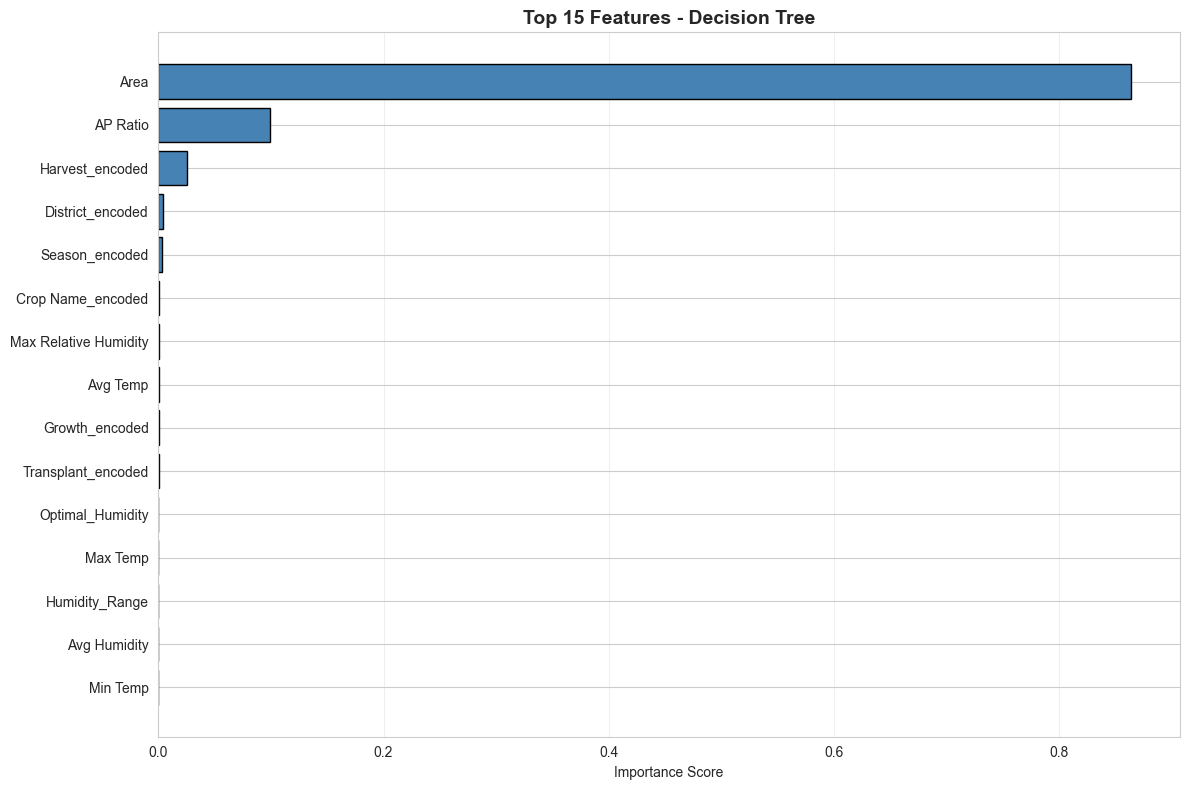

In [35]:
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"Best Model: {best_model_name}")

if best_model_name in ['Random Forest', 'XGBoost', 'Decision Tree']:
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Top 15 Important Features:")
    print(feature_importance.head(15).to_string(index=False))
    
    # Plot
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', edgecolor='black')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance Score')
    plt.title(f'Top 15 Features - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

In [36]:

print("=== Tuning Decision Tree Hyperparameters ===")

param_grid = {
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

dt_model = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt_model, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"\n✓ Best Parameters: {grid_search.best_params_}")
print(f"✓ Best CV R² Score: {grid_search.best_score_:.4f}")

# Test the tuned model
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"Tuned Model Performance:")
print(f"   MAE:  {mae_tuned:,.2f}")
print(f"   RMSE: {rmse_tuned:,.2f}")
print(f"   R²:   {r2_tuned:.4f}")


=== Tuning Decision Tree Hyperparameters ===
Fitting 3 folds for each of 108 candidates, totalling 324 fits

✓ Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8}
✓ Best CV R² Score: 0.9127
Tuned Model Performance:
   MAE:  3,595.03
   RMSE: 26,957.61
   R²:   0.8461


In [49]:
# Comparison: Tuned vs Original Decision Tree
print("=== TUNING ANALYSIS ===")
print(f"Original Decision Tree R²: {results['Decision Tree']['R2']:.4f}")
print(f"Tuned Decision Tree R²:    {r2_tuned:.4f}")
print(f"Performance Change:        {r2_tuned - results['Decision Tree']['R2']:.4f}")

if results['Decision Tree']['R2'] > r2_tuned:
    print("INSIGHT: Hyperparameter tuning REDUCED performance!")
    print("    Using original Decision Tree model instead")
    print("    Default parameters work best!")
    best_model_name = "Decision Tree (Original)"
    best_predictions = results['Decision Tree']['predictions']
    best_r2 = results['Decision Tree']['R2']
else:
    best_model_name = "Decision Tree (Tuned)"
    best_predictions = y_pred_tuned
    best_r2 = r2_tuned

=== TUNING ANALYSIS ===
Original Decision Tree R²: 0.8677
Tuned Decision Tree R²:    0.8461
Performance Change:        -0.0216
INSIGHT: Hyperparameter tuning REDUCED performance!
    Using original Decision Tree model instead
    Default parameters work best!


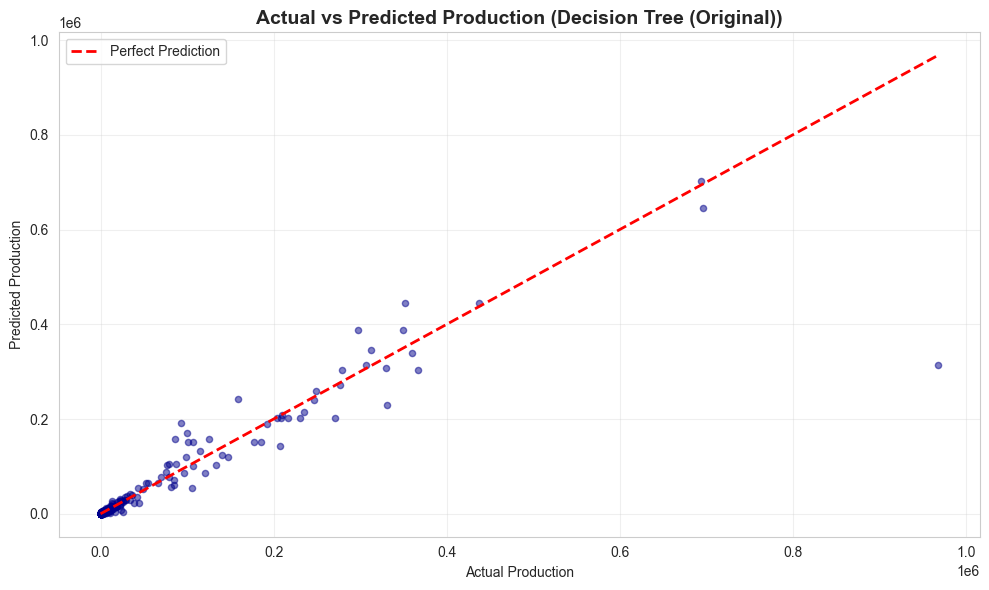

In [50]:
# Actual vs Predicted (Using Best Model)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_predictions, alpha=0.5, c='darkblue', s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.title(f'Actual vs Predicted Production ({best_model_name})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

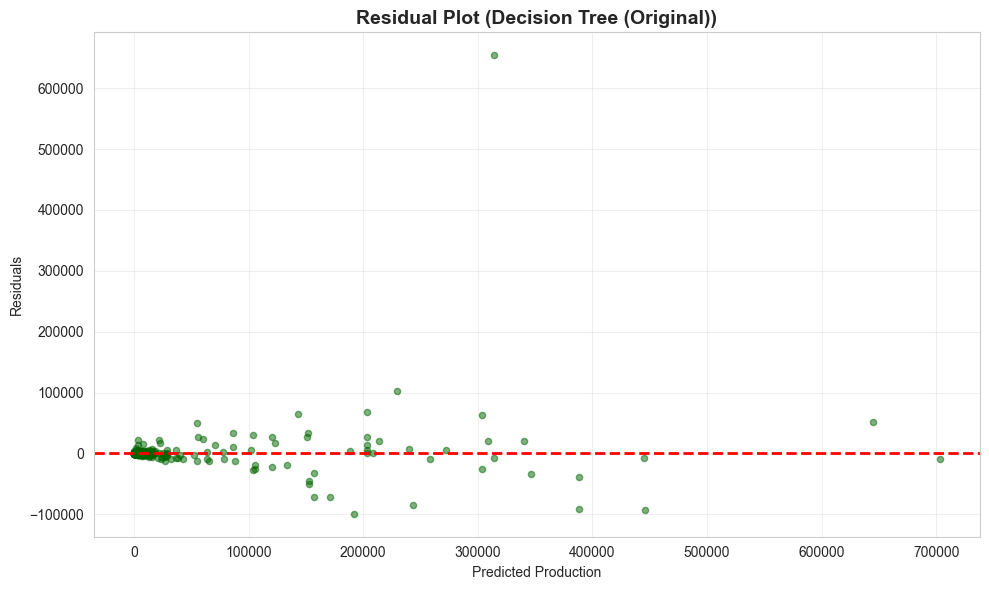

In [51]:
# Residuals (Using Best Model)
residuals = y_test - best_predictions
plt.figure(figsize=(10, 6))
plt.scatter(best_predictions, residuals, alpha=0.5, c='darkgreen', s=20)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Production')
plt.ylabel('Residuals')
plt.title(f'Residual Plot ({best_model_name})', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('residuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [52]:
# Feature Importance from Best Model
if "Original" in best_model_name:
    best_model = results['Decision Tree']['model']
else:
    best_model = tuned_model

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("ANALYSIS COMPLETE!")
print("="*80)
print("Generated Files:")
print("   - production_distribution.png")
print("   - top_crops.png")
print("   - season_production.png")
print("   - climate_features.png")
print("   - correlation.png")
print("   - area_vs_production.png")
print("   - model_comparison.png")
print("   - feature_importance.png")
print("   - actual_vs_predicted.png")
print("   - residuals.png")

print("\nKEY INSIGHTS:")
print(f"   1. Best Model: {best_model_name} with R² = {best_r2:.4f}")
print(f"   2. Most Important Feature: {feature_importance.iloc[0]['Feature']}")
print(f"   3. Total Crops Analyzed: {df_clean['Crop Name'].nunique()}")
print(f"   4. Total Districts: {df_clean['District'].nunique()}")
print(f"   5. Model can explain {best_r2*100:.2f}% of production variance")


ANALYSIS COMPLETE!
Generated Files:
   - production_distribution.png
   - top_crops.png
   - season_production.png
   - climate_features.png
   - correlation.png
   - area_vs_production.png
   - model_comparison.png
   - feature_importance.png
   - actual_vs_predicted.png
   - residuals.png

KEY INSIGHTS:
   1. Best Model: Decision Tree (Original) with R² = 0.8677
   2. Most Important Feature: Area
   3. Total Crops Analyzed: 73
   4. Total Districts: 64
   5. Model can explain 86.77% of production variance
